# Ways to create dataset

Importing relevant libraries and modules

In [2]:
import json
import math
import os
from pprint import pprint

import numpy as np
import tensorflow as tf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print(tf.version.VERSION)

2.13.0


**Using tf.data.Dataset.from_tensor_slices - when loading data from memory (already available lists/slices of data)**

In [3]:
def create_dataset(X, Y, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

----------------------------

**Using tf.data.experimental.make_csv_dataset - when loading data from csv**

 tf.data.experimental.make_csv_dataset is a high-level tf.data API to read the CSV files

make_csv_dataset is a handy high-level function that offers a lot of functionalities, but sometimes it doesn't fit some use cases.

In [4]:
def create_dataset(pattern):
    return tf.data.experimental.make_csv_dataset(
        pattern, 1, CSV_COLUMNS, DEFAULTS
    )

--------------------------------------

**Using tf.data.TextLineDataset - when loading text-based data including csv**

For text-based data including CSV, we can use TextLineDataset for low-level API.

In [1]:
def parse_csv(row):
    ds = tf.strings.split(row, ",")
    label = ds[0]
    features = ds[2:6]  # use some features only
    return features, label

def create_dataset(pattern):
    ds = tf.data.TextLineDataset(pattern)
    ds = ds.map(parse_csv).batch(batch_size, drop_remainder=True)
    return ds

--------------------------------------------------------------------------------------------------------------------------------

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

--------------------------------------------------------------------------------------------------------------------------------

# Ways to create image dataset

Keras has some convenient methods to read in image data. 

* [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is great for small local datasets. A tutorial on how to use it can be found [here](https://www.tensorflow.org/tutorials/load_data/images)

* [tf.data.datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to build a generator based on files in a Google Cloud Storage Bucket (if we have so many images, it doesn't fit on a local machine).

-------------------------------------------------------

# Reading the images

Importing relevant libraries and modules

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

import pathlib

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Softmax,
)

**tf.io.read_file :** to read the file contents, output is a Base64 image string

In [37]:
img = tf.io.read_file("gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg") # Base64 image string

* **tf.image.decode_jpeg** can decode Base64 image string into an integer array
* **tf.image.convert_image_dtype** can cast the integer array into 0 -1 range float
* **tf.image.resize** can make image dimensions consistent for our neural network

In [38]:
def decode_img(img, reshape_dims):
    img = tf.image.decode_jpeg(img) # tf.image.decode_jpeg can decode Base64 image string into an integer array
    print("\n tf.image.decode_jpeg : Convert base64 image string into an integer array \n")
    print(img)
    img = tf.image.convert_image_dtype(img, tf.float32) # tf.image.convert_image_dtype can cast the integer array into 0 -1 range float
    print("\n tf.image.convert_image_dtype : Cast the integer array into 0 - 1 range float \n")
    print(img)
    img = tf.image.resize(img, reshape_dims) # tf.image.resize can make image dimensions consistent for our neural network
    print("\n tf.image.resize : Keep image dimensions consistent for our neural network \n")
    print(img)
    return img

In [39]:
img = decode_img(img, [224, 224])


 tf.image.decode_jpeg : Convert base64 image string into an integer array 

tf.Tensor(
[[[  0   5   0]
  [  0   5   0]
  [  0   5   0]
  ...
  [116 100  40]
  [119 106  61]
  [125 116  77]]

 [[  0   5   0]
  [  0   5   0]
  [  0   5   0]
  ...
  [121 104  34]
  [123 110  58]
  [131 119  81]]

 [[  0   5   0]
  [  0   5   0]
  [  0   5   0]
  ...
  [123 106  18]
  [126 110  48]
  [134 119  78]]

 ...

 [[  0  11   0]
  [  0  11   0]
  [  0  12   0]
  ...
  [102 101  47]
  [117 115  67]
  [127 124  79]]

 [[  0  11   0]
  [  0  11   0]
  [  0  12   0]
  ...
  [102 101  45]
  [116 114  65]
  [125 123  75]]

 [[  0  10   0]
  [  0  11   0]
  [  0  11   0]
  ...
  [103 101  44]
  [115 113  62]
  [121 121  71]]], shape=(213, 320, 3), dtype=uint8)

 tf.image.convert_image_dtype : Cast the integer array into 0 - 1 range float 

tf.Tensor(
[[[0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  ...
  [0.454902   0.3921569  0.15686275]
 

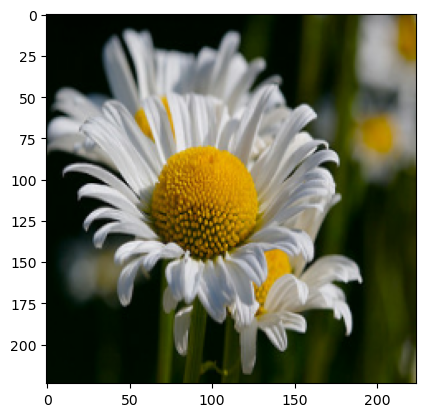

In [30]:
plt.imshow(img.numpy())

-----------------------------------------

* **tf.io.decode_csv :** reads in csv rows (or each line in a csv file) 

* **tf.math.equal :** formats our label such that it's a boolean array with a truth value corresponding to the output class

In [72]:
def decode_csv(csv_row): # csv_row consists of a file path and the flower class
    
    record_defaults = ["path", "flower"] # Default values for the dataset
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults) # tf.io.decode_csv reads every row in the csv
    
    image_bytes = tf.io.read_file(filename=filename) # output: base64 image string
    image_bytes = tf.image.decode_jpeg(image_bytes) # output: an integer array
    image_bytes = tf.image.convert_image_dtype(image_bytes, tf.float32) # output: 0 - 1 range float
    image_bytes = tf.image.resize(image_bytes, [224, 224]) # output: image dimension
    
    label = tf.math.equal(CLASS_NAMES, label_string) # formats label to a boolean array with a truth value corresponding to the output class
    
    return image_bytes, label # Returning a base64 image string and a boolean array with True corresponding to a particular class

In [73]:
def load_dataset(csv_of_filenames, batch_size, training=True):
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames)
    dataset = dataset.map(decode_csv).cache()
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

In [74]:
CLASS_NAMES = ['sunflowers' 'daisy' 'dandelion' 'roses' 'tulips']
train_data = load_dataset("img_flower_photos_train_set.csv", batch_size=1)

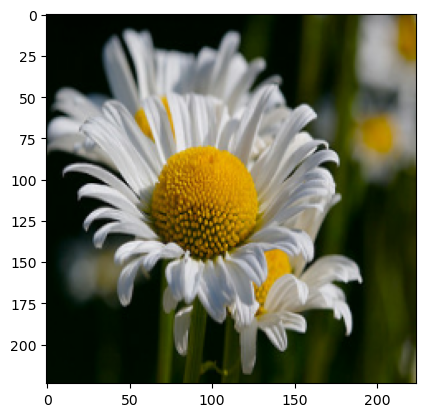

In [82]:
for i, l in train_data.take(1):
    img = i[0]
    plt.imshow(img.numpy())